Multilabel text classification - Product experience analysis

In [50]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

1. Loading data and conducting EAD  

1.1 Load data

In [51]:
#load data
df = pd.read_csv("C:/Users/C973119/Downloads/VSC/multilabel classification/input.csv")
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print(df.head())

Number of rows: 931
Number of columns: 5
                                            feedback  accuracy  lack_update  \
0  a little slow and you mis read the meter… our ...         1            0   
1                                         stop lying         1            0   
2                                   answer the phone         0            0   
3  explain the reason for these now common brief ...         0            1   
4                     fix the power in under 8 hours         0            0   

   digital_func  length  
0             1       1  
1             0       0  
2             0       0  
3             0       0  
4             0       1  


1.2 Check missing values

In [52]:
#check missing values
print(df.isnull().sum())

feedback        0
accuracy        0
lack_update     0
digital_func    0
length          0
dtype: int64


1.3 Calculate number of feedback in each painpoint category

In [53]:
# painpoint categories
painpoints = list(df.columns)
painpoints = painpoints[1:]
print(painpoints)

['accuracy', 'lack_update', 'digital_func', 'length']


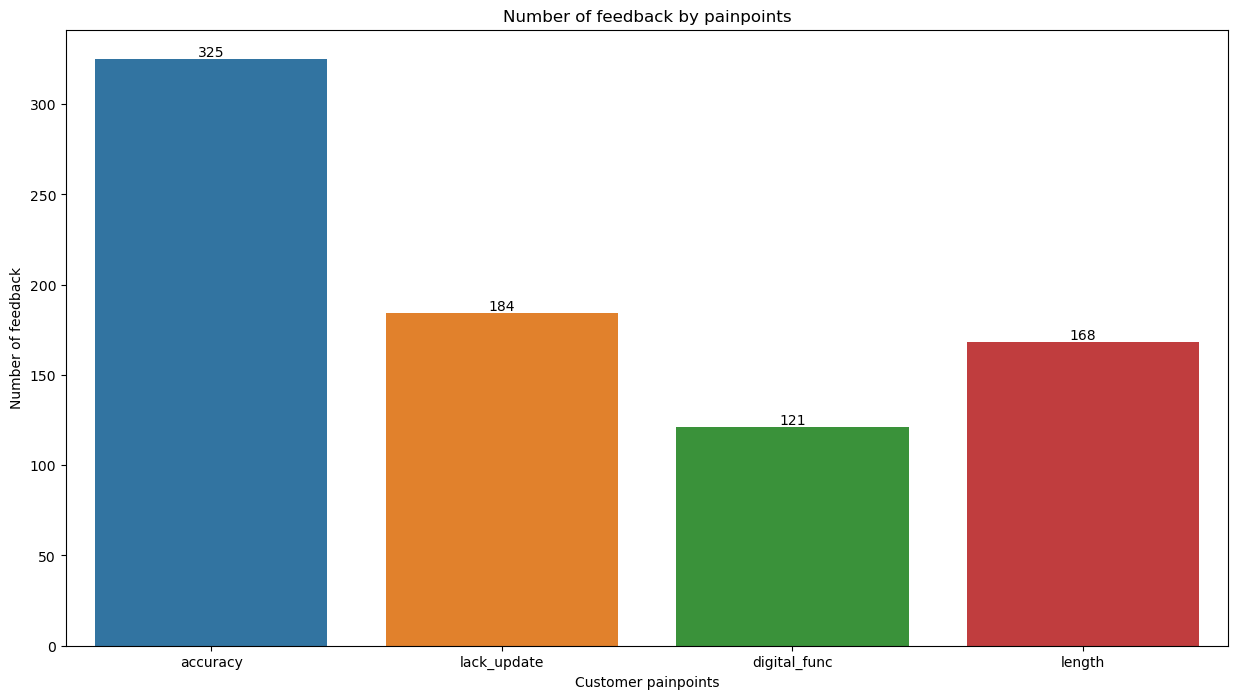

In [54]:
#calculate number of feedback in each painpoint category
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

ax = sns.barplot(x=painpoints, y=df.iloc[:,1:].sum())
plt.title('Number of feedback by painpoints')
plt.xlabel('Customer painpoints')
plt.ylabel('Number of feedback')
ax.bar_label(ax.containers[0])

plt.show()

1.4 Calculate numbers of feedback that have multiple painpoints

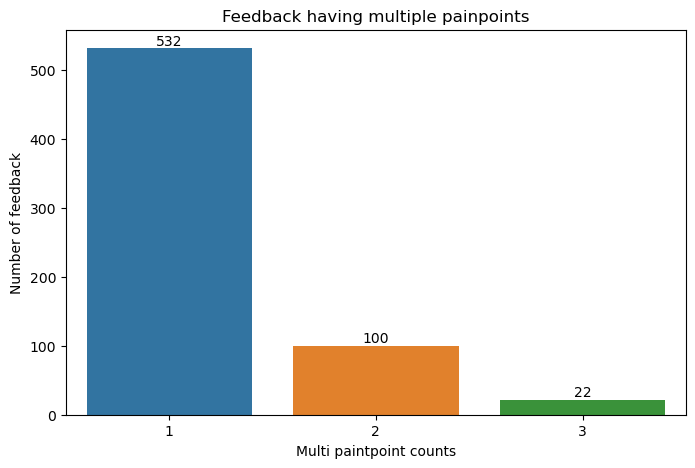

In [91]:
# calculate numbers of feedback that have multiple painpoints
labelcounts = df.iloc[:,1:].sum(axis = 1).value_counts()
multilabel_counts = labelcounts[labelcounts.index != 0]

plt.figure(figsize=(8,5))

ax = sns.barplot(x=multilabel_counts.index, y=multilabel_counts.values)
plt.title('Feedback having multiple painpoints')
plt.xlabel('Multi paintpoint counts')
plt.ylabel('Number of feedback')
ax.bar_label(ax.containers[0])

plt.show()

1.5 Examine most used words in customer feedback for each painpoint category

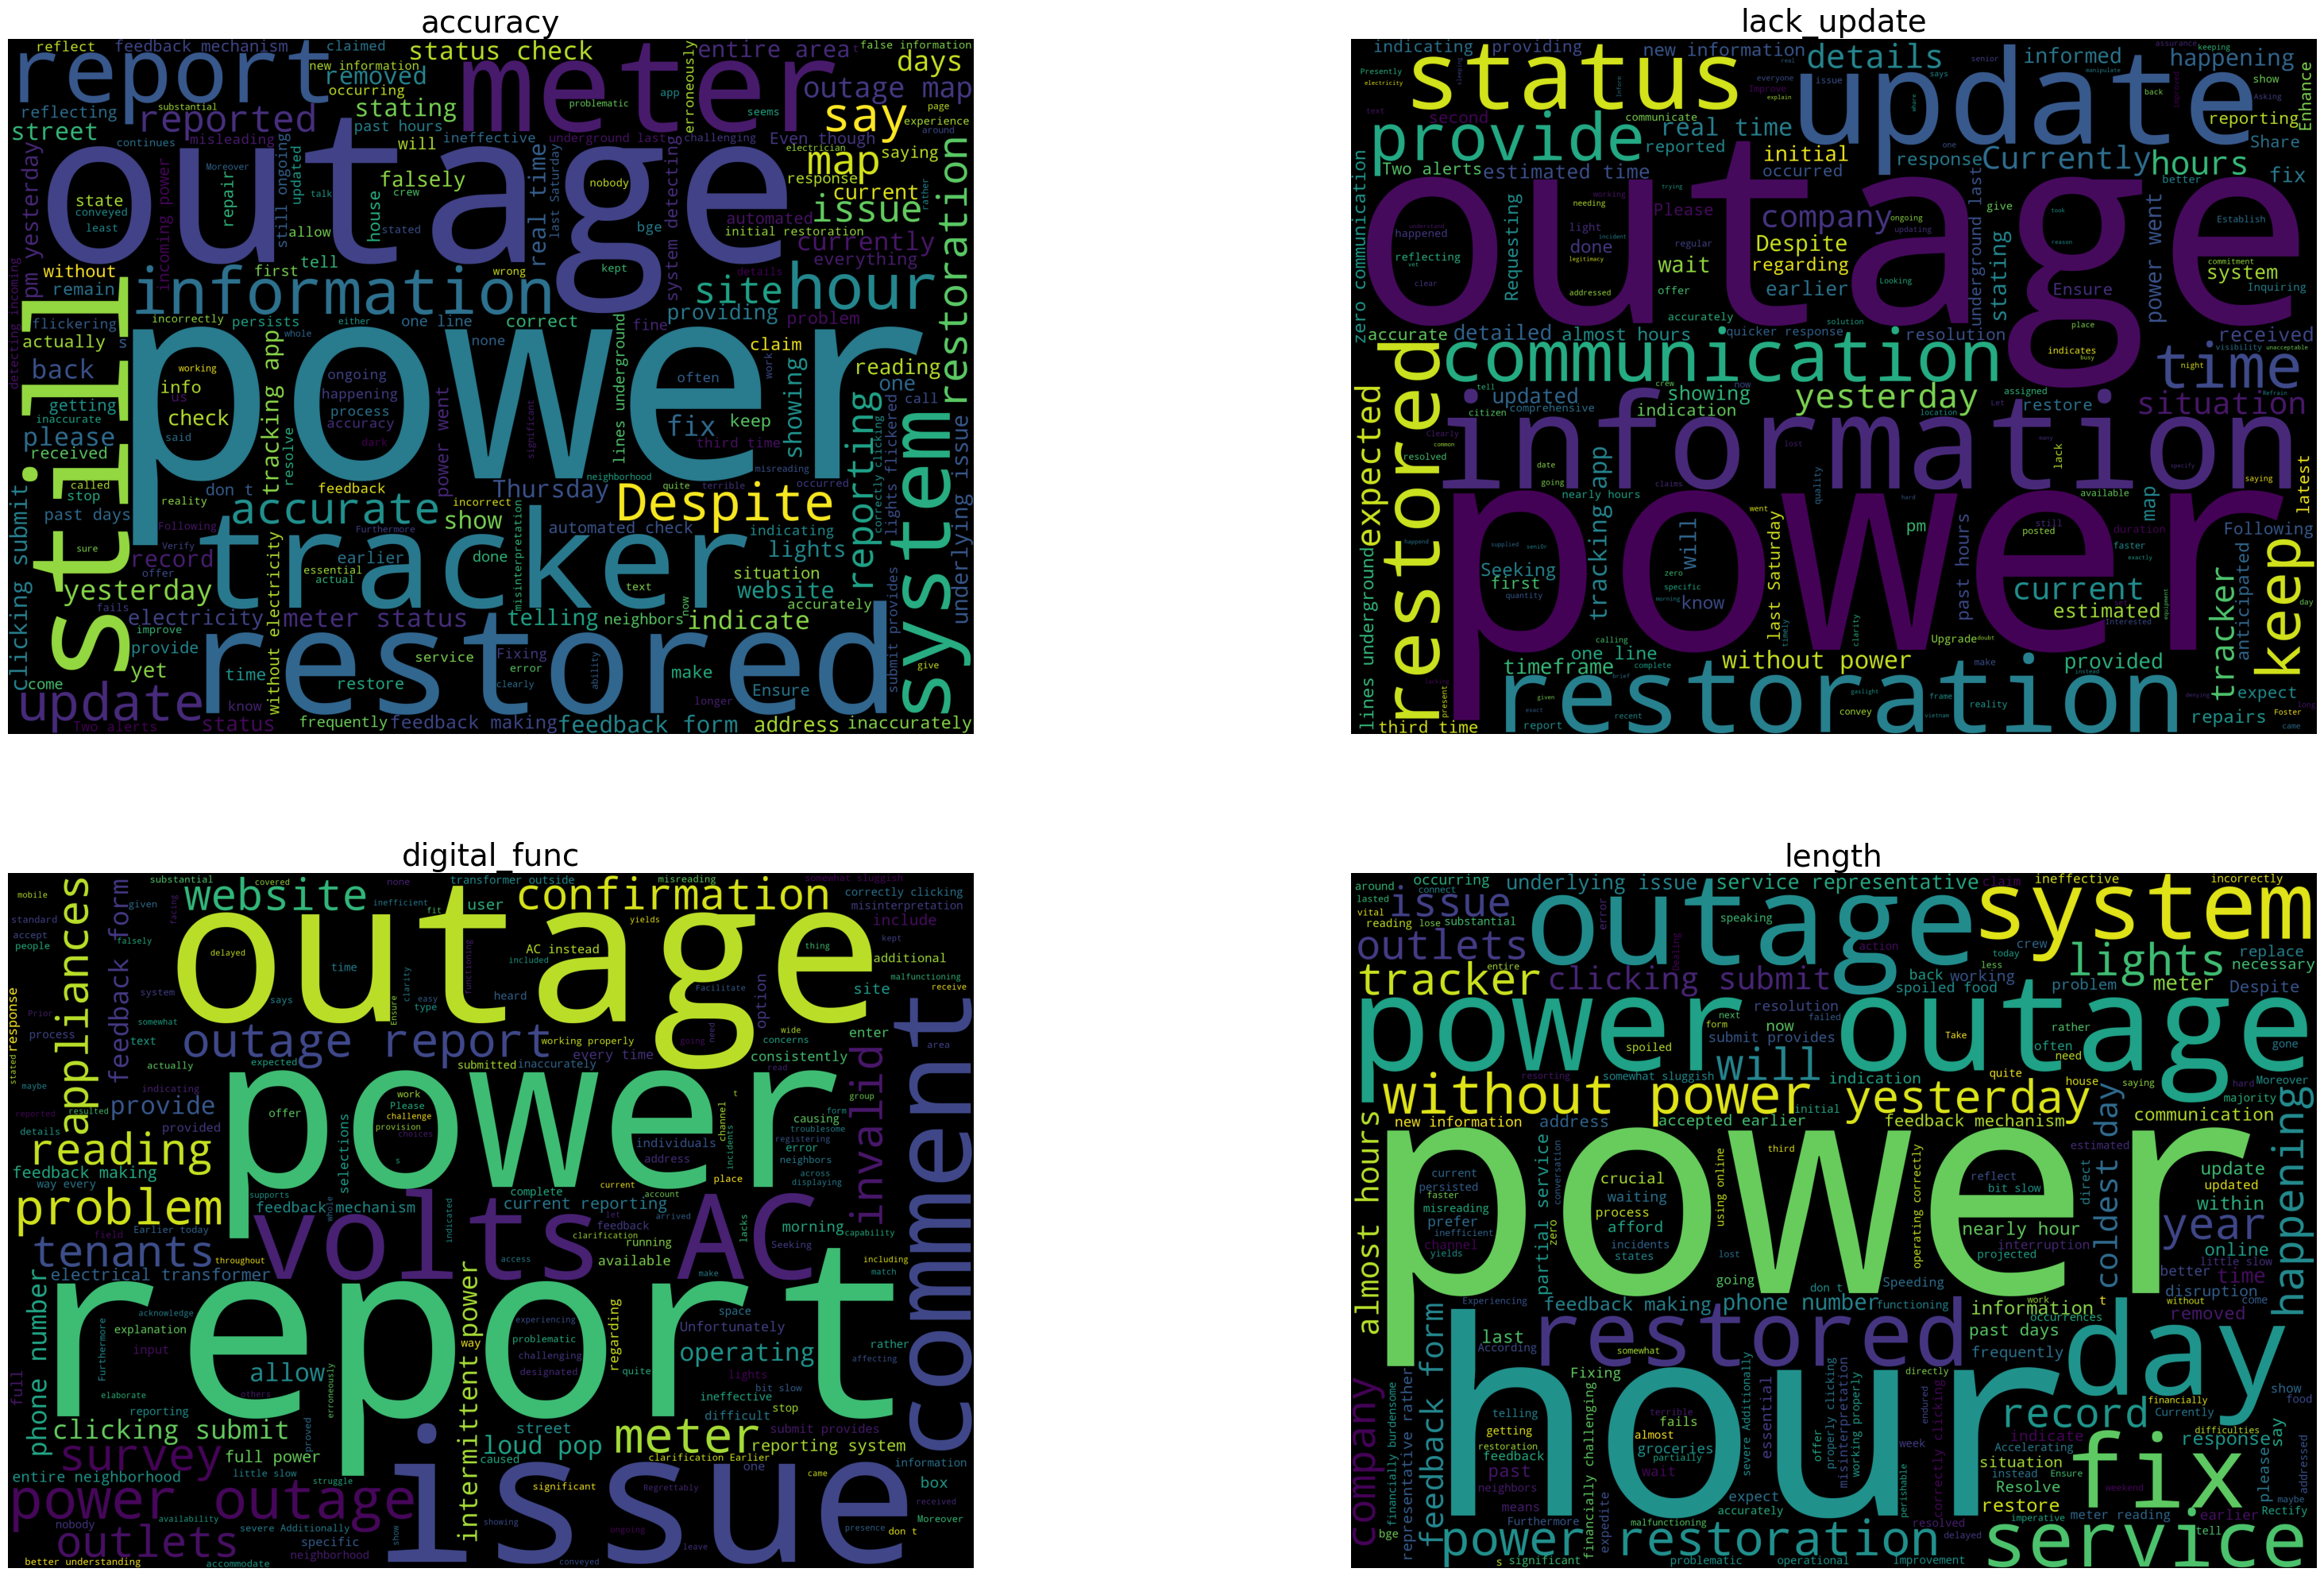

In [56]:
# wordcloud
from wordcloud import WordCloud

plt.figure(figsize=(40,25))

#accuracy label
sub = df[df.accuracy ==1]
text = sub.feedback.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1800, background_color='black').generate(text)
plt.subplot(2,2,1)
plt.axis('off')
plt.title('accuracy', fontsize=28)
plt.imshow(wordcloud)

#lack_update label
sub = df[df.lack_update ==1]
text = sub.feedback.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1800, background_color='black').generate(text)
plt.subplot(2,2,2)
plt.axis('off')
plt.title('lack_update', fontsize=28)
plt.imshow(wordcloud)

#digital_func label
sub = df[df.digital_func ==1]
text = sub.feedback.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1800, background_color='black').generate(text)
plt.subplot(2,2,3)
plt.axis('off')
plt.title('digital_func', fontsize=28)
plt.imshow(wordcloud)

#digital_func label
sub = df[df.length ==1]
text = sub.feedback.str.cat(sep=' ')
wordcloud = WordCloud(width=2500, height=1800, background_color='black').generate(text)
plt.subplot(2,2,4)
plt.axis('off')
plt.title('length', fontsize=28)
plt.imshow(wordcloud)

plt.show()

2. Processing customer feedback text

2.1 Customize stop words

In [57]:
# text pre-processing

import spacy

#initiate nlp object and customize stop words list
nlp = spacy.load('en_core_web_sm')

stopwords = spacy.lang.en.stop_words.STOP_WORDS
remove = {'no', 'not', 'out', 'on', 'why', "n't", 'n’t', 'n‘t', 'off', 'until', 'still'}
stop = {'road', 'md', 'house', 'generator', 'etc', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec','mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'}

for element in remove:
    stopwords.discard(element)
for element in stop:
    stopwords.add(element)

2.2 Lemmatize the text

In [58]:
# lemmatize text
def lemmatize(sent):
    doc = nlp(sent)
    lem = [token.lemma_ for token in doc]
    c_lem = [l for l in lem if l.isalpha() and l not in stopwords]
    lemma = ' '.join(c_lem)
    return lemma

df['feedback'] = df['feedback'].str.lower()
df['feedback'] = df['feedback'].astype(str)
df['feedback'] = df['feedback'].apply(lemmatize)

In [59]:
print(df.head())

                                            feedback  accuracy  lack_update  \
0  little slow mis read meter power out hard form...         1            0   
1                                           stop lie         1            0   
2                                       answer phone         0            0   
3           explain reason common brief power outage         0            1   
4                                     fix power hour         0            0   

   digital_func  length  
0             1       1  
1             0       0  
2             0       0  
3             0       0  
4             0       1  


3. Train model

3.1 Prepare train and test datasets

In [78]:
# split dataset into train and test sets

x = df['feedback']
y = df.drop('feedback',axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=111, test_size=0.3, shuffle=True, stratify=y)

# vectorize the text
tfidf = TfidfVectorizer(strip_accents='ascii', analyzer='word', ngram_range=(1,3), norm='l2')

x_train_bow = tfidf.fit_transform(x_train)
x_test_bow = tfidf.transform(x_test)

3.2 Train model

In [79]:
# #train mode
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

#initialize a dictionary to store model
models = {}

#create and train the model
for pain in painpoints:
    print('{} label:'.format(pain.capitalize()))

    # Using pipeline to apply logistic regression and one vs rest classifier
    lrpl = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag', random_state=111), n_jobs=-1))])

    #fit model
    lrpl.fit(x_train_bow, train[pain]) # it's a good practice to turn the bow matrix into array to improve speed
    models[pain] = lrpl

    #calculating test accuracy
    prediction = lrpl.predict(x_test_bow)
    print('Test accuracy is {:.4f}'.format(accuracy_score(y_test[pain], prediction)))
    print("\n")


Accuracy label:
Test accuracy is 0.9179


Lack_update label:
Test accuracy is 0.8750


Digital_func label:
Test accuracy is 0.8786


Length label:
Test accuracy is 0.8393




4. Apply model for further analysis

4.1 Run model and append prediction results to dataset

In [67]:
# run model on a dataset & extract
# pre-process text
output = pd.read_csv("C:/Users/C973119/Downloads/VSC/multilabel classification/customer-feedback.csv")

output['feedback'] = output['feedback'].str.lower()
output['feedback'] = output['feedback'].astype(str)
output['feedback'] = output['feedback'].apply(lemmatize)

# run model
x_bow = tfidf.transform(output['feedback'])
for pain in painpoints:
    output[pain] = models[pain].predict(x_bow)

# save to local PC if needed
output.to_excel('output.xlsx', index=False)

4.2 Identify most problematic customer painpoints

In [70]:
# perform analysis on the output
# calculate number of feedback by painpoint
print(output.iloc[:,47:].sum())
print("\n")

# calculate customer satisfaction for each painpoint
satisfactions = []

for pain in painpoints:
    sat = output[output[pain] ==1]['Digital Satisfaction'].mean()
    satisfactions.append((pain, f'{sat:.2f}'))

satisfactions = pd.DataFrame(satisfactions, columns=['painpoint','satisfaction'])
print(satisfactions)

accuracy        398
lack_update      83
digital_func      8
length           46
dtype: int64


      painpoint satisfaction
0      accuracy         2.53
1   lack_update         3.08
2  digital_func         3.50
3        length         1.04
